# 课程设计 - Network Compression_1 (Architecuture Design)

若有问题，请联系助教杜景锐、龚冬兴

# 任务提示

课程设计的任务是 - Neural Network Compression。
Compression有很多种类型，在这里我们需要完成的是以下两种，分別是:

* 知识蒸馏 Knowledge Distillation
* 用少量参数来做CNN Architecture Design

在这个notebook中我们会介绍MobileNet v1的Architecture Design。

# Architecture Design

## 几种卷积的实现细节
```python
# 一般的Convolution, weight大小 = in_chs * out_chs * kernel_size^2
nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding)

# Group Convolution, Group数目可以自行控制，表示要分成几群。其中in_chs和out_chs必须要可以被groups整除。(不然沒办法分群。)
nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding, groups=groups)

# Depthwise Convolution, 输入chs=输出chs=Groups数目, weight大小 = in_chs * kernel_size^2
nn.Conv2d(in_chs, out_chs=in_chs, kernel_size, stride, padding, groups=in_chs)

# Pointwise Convolution, 也就是1 by 1 convolution, weight大小 = in_chs * out_chs
nn.Conv2d(in_chs, out_chs, 1)
```

**更新pip**

In [1]:
!python -m pip install --upgrade pip
!pip install -U albumentations
!pip install timm
!pip install torchsummary
!pip install matplotlib
!pip install --upgrade opencv-python

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 2.1 MB 78.8 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.2.2
    Uninstalling pip-21.2.2:
      Successfully uninstalled pip-21.2.2
Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.5/113.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 MB 39.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.2/29.2 MB 55.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 28.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 42.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 56.3 MB/s eta 0:00:00:00:01
  Using cached http://repo.myhuawei

**把数据从OBS复制到服务器中**

In [2]:
import moxing as mox 
# 需修改为自己的OBS目录
mox.file.copy('obs://tong-network/food-11.zip', '/home/ma-user/work/food-11.zip') # 复制数据到当前路径

INFO:root:Using MoXing-v2.0.1.rc0.ffd1c0c8-ffd1c0c8
INFO:root:Using OBS-Python-SDK-3.20.9.1


**解压数据**

In [ ]:
!unzip food-11.zip

In [2]:
import os
import glob
import time
import timm
import numpy as np
# from PIL import Image
import PIL.Image as Image
import pandas as pd
import albumentations as A  # 数据增强库
import matplotlib.pyplot as plt

from tqdm import tqdm  # 显示进度条
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

%matplotlib inline

/home/ma-user/anaconda3/envs/PyTorch-1.8/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 分别读入 training set、validation set、testing set 的文件路径


dataset_dir = 'food-11/'    # todo: 更换自己的文件路径
# dataset_dir = '/path/to/your/dataset/dir'
train_files = glob.glob(os.path.join(dataset_dir, 'training', '*'))  # 返回列表[training目录下所有文件的绝对路径]
val_files = glob.glob(os.path.join(dataset_dir, 'validation', '*'))

print(len(train_files), len(val_files))

9866 3430


# Dataset
在 Pytorch 中，我们可以利用 torch.utils.data 的 Dataset 及 DataLoader 來"包装" data，使后续的 training 及 testing 更為方便。

Dataset 需要 overload 两个函数：\_\_len\_\_ 及 \_\_getitem\_\_

\_\_len\_\_ 必须要回传 dataset 的大小，而 \_\_getitem\_\_ 则定义了当函数利用 [ ] 取值時，dataset 应该要怎么回传资料。

实际上我们并不会直接使用到这两个函数，但是使用 DataLoader 在 enumerate Dataset 时会使用到，沒有overload的话在函数运行阶段会出现 error。


In [4]:
#training 时做 data augmentation
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5), # 水平翻转，概率为0.5
    
    A.Resize(224, 224, always_apply=True),  # 将不同尺寸的图像缩放到同一尺寸
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # 使用imagenet的均值和方差进行normalization
    ToTensorV2(), # 将numpy转换为Tensor， 并将图像（H,W,3）转换为（3,H,W）
])  # 其他方式的数据增强请参考官方文档

#testing 时候不需做 data augmentation
test_transform = A.Compose([
    A.Resize(224, 224, always_apply=True),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

class ImgDataset(Dataset):
    def __init__(self, files_list, transform=None, mode='train'):
        self.files_list = files_list
        self.transform = transform
        self.mode = mode
    
    def __getitem__(self, index):
        file = self.files_list[index]
        image = np.array(Image.open(file))
        
        if self.transform is not None:
            aug = self.transform(image=image)
            image = aug['image']
        
        if self.mode in ['train', 'val']: 
            label = int(os.path.basename(file).split('_')[0])
            return image, label

        else:
            return image
        
    def __len__(self):
        return len(self.files_list)

In [5]:
batch_size = 64
train_set = ImgDataset(train_files, train_transform, mode='train')
val_set = ImgDataset(val_files, test_transform, mode='val')
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)

# Model

In [6]:
class StudentNet(nn.Module):
    '''
      在这个Net里面，我们会使用Depthwise & Pointwise Convolution Layer來叠model。
      你会发現，将原本的Convolution Layer换成Dw & Pw以后，Accuracy通常不会降很多。

      另外，取名为StudentNet是因為个odel等会要做Knowledge Distillation。
    '''

    def __init__(self, base=16, width_mult=1):
        '''
          Args:
            base: 这个model一开始的channle数量，每过一层都会*2，直到base*16为止。
            width_mult:为了之後的Network Pruning使用，在base*8 chs的Layer上会 * width_mult代表剪枝后的ch数量。        
        '''
        super(StudentNet, self).__init__()
        multiplier = [1, 2, 4, 8, 16, 16, 16, 16]

        # bandwidth: 每一层Layer所使用的ch數量
        bandwidth = [ base * m for m in multiplier]

        # 我们只Pruning第三层以后的Layer
        for i in range(3, 7):
            bandwidth[i] = int(bandwidth[i] * width_mult)

        self.cnn = nn.Sequential(
            # 第一层我们通常不会拆解Convolution Layer。
            # nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding)
            nn.Sequential(
                nn.Conv2d(3, bandwidth[0], 3, 1, 1),  # bandwidth[0]=1*16
                nn.BatchNorm2d(bandwidth[0]),
                nn.ReLU6(),
                nn.MaxPool2d(2, 2, 0),
            ),
            # 接下来每一个Sequential Block都一样，所以我们只讲一个block
            nn.Sequential(
                # Depthwise Convolution 卷积层（x, x, x）
                nn.Conv2d(bandwidth[0], bandwidth[0], 3, 1, 1, groups=bandwidth[0]),
                # Batch Normalization
                nn.BatchNorm2d(bandwidth[0]),
                # ReLU6 是限制Neuron最小只会到0，最大只会到6。 MobileNet系列都是使用ReLU6。
                # 使用ReLU6的原因是因为如果数字太大，会不好压到float16 / or further qunatization，因此才給个限制。
                nn.ReLU6(),
                # Pointwise Convolution
                nn.Conv2d(bandwidth[0], bandwidth[1], 1),
                # 过完Pointwise Convolution不需要再做ReLU，经验上Pointwise + ReLU效果都会变差。
                nn.MaxPool2d(2, 2, 0),
                # 每过完一个Block就Down Sampling
            ),

            nn.Sequential(
                nn.Conv2d(bandwidth[1], bandwidth[1], 3, 1, 1, groups=bandwidth[1]),
                nn.BatchNorm2d(bandwidth[1]),
                nn.ReLU6(),
                nn.Conv2d(bandwidth[1], bandwidth[2], 1),
                nn.MaxPool2d(2, 2, 0),
            ),

            nn.Sequential(
                nn.Conv2d(bandwidth[2], bandwidth[2], 3, 1, 1, groups=bandwidth[2]),
                nn.BatchNorm2d(bandwidth[2]),
                nn.ReLU6(),
                nn.Conv2d(bandwidth[2], bandwidth[3], 1),
                nn.MaxPool2d(2, 2, 0),
            ),

            # 到这个为止是因为图片被Down Sample很多次了，所以就不做MaxPool
            nn.Sequential(
                nn.Conv2d(bandwidth[3], bandwidth[3], 3, 1, 1, groups=bandwidth[3]),
                nn.BatchNorm2d(bandwidth[3]),
                nn.ReLU6(),
                nn.Conv2d(bandwidth[3], bandwidth[4], 1),
            ),

            nn.Sequential(
                nn.Conv2d(bandwidth[4], bandwidth[4], 3, 1, 1, groups=bandwidth[4]),
                nn.BatchNorm2d(bandwidth[4]),
                nn.ReLU6(),
                nn.Conv2d(bandwidth[4], bandwidth[5], 1),
            ),

            nn.Sequential(
                nn.Conv2d(bandwidth[5], bandwidth[5], 3, 1, 1, groups=bandwidth[5]),
                nn.BatchNorm2d(bandwidth[5]),
                nn.ReLU6(),
                nn.Conv2d(bandwidth[5], bandwidth[6], 1),
            ),

            nn.Sequential(
                nn.Conv2d(bandwidth[6], bandwidth[6], 3, 1, 1, groups=bandwidth[6]),
                nn.BatchNorm2d(bandwidth[6]),
                nn.ReLU6(),
                nn.Conv2d(bandwidth[6], bandwidth[7], 1),
            ),

            # 这边我们用Global Average Pooling。
            # 如果输入图片大小不一样的话，就会因为Global Average Pooling压成一样的形狀，这样子接下来做FC就不会对不起来。
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Sequential(
            # 这边我们直接Project到11维输出答案。  数据集food种类为11
            nn.Linear(bandwidth[7], 11),
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)


In [28]:
class StudentNet(nn.Module):
    '''
      在这个Net里面，我们会使用Depthwise & Pointwise Convolution Layer來叠model。
      你会发現，将原本的Convolution Layer换成Dw & Pw以后，Accuracy通常不会降很多。

      另外，取名为StudentNet是因為个odel等会要做Knowledge Distillation。
    '''

    def __init__(self, base=16, width_mult=1):
        '''
          Args:
            base: 这个model一开始的channle数量，每过一层都会*2，直到base*16为止。
            width_mult:为了之後的Network Pruning使用，在base*8 chs的Layer上会 * width_mult代表剪枝后的ch数量。        
        '''
        super(StudentNet, self).__init__()
        multiplier = [1, 2, 4, 8, 16, 16, 16, 16]

        # bandwidth: 每一层Layer所使用的ch數量
        bandwidth = [ base * m for m in multiplier]

        # 我们只Pruning第三层以后的Layer
        for i in range(3, 7):
            bandwidth[i] = int(bandwidth[i] * width_mult)

        self.cnn = nn.Sequential(
            # 第一层我们通常不会拆解Convolution Layer。
            # nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding)
            nn.Sequential(
                nn.Conv2d(3, bandwidth[0], 3, 1, 1),  # bandwidth[0]=1*16
                nn.BatchNorm2d(bandwidth[0]),
                nn.Hardswish(),
                nn.MaxPool2d(2, 2, 0),
            ),
            # 接下来每一个Sequential Block都一样，所以我们只讲一个block
            nn.Sequential(
                # Depthwise Convolution 卷积层（x, x, x）
                nn.Conv2d(bandwidth[0], bandwidth[0], 3, 1, 1, groups=bandwidth[0]),
                # Batch Normalization
                nn.BatchNorm2d(bandwidth[0]),
                # ReLU6 是限制Neuron最小只会到0，最大只会到6。 MobileNet系列都是使用ReLU6。
                # 使用ReLU6的原因是因为如果数字太大，会不好压到float16 / or further qunatization，因此才給个限制。
                nn.Hardswish(),
                # Pointwise Convolution
                nn.Conv2d(bandwidth[0], bandwidth[1], 1),
                # 过完Pointwise Convolution不需要再做ReLU，经验上Pointwise + ReLU效果都会变差。
                nn.MaxPool2d(2, 2, 0),
                # 每过完一个Block就Down Sampling
            ),

            nn.Sequential(
                nn.Conv2d(bandwidth[1], bandwidth[1], 3, 1, 1, groups=bandwidth[1]),
                nn.BatchNorm2d(bandwidth[1]),
                nn.Hardswish(),
                nn.Conv2d(bandwidth[1], bandwidth[2], 1),
                nn.MaxPool2d(2, 2, 0),
            ),

            nn.Sequential(
                nn.Conv2d(bandwidth[2], bandwidth[2], 3, 1, 1, groups=bandwidth[2]),
                nn.BatchNorm2d(bandwidth[2]),
                nn.Hardswish(),
                nn.Conv2d(bandwidth[2], bandwidth[3], 1),
                nn.MaxPool2d(2, 2, 0),
            ),

            # 到这个为止是因为图片被Down Sample很多次了，所以就不做MaxPool
            nn.Sequential(
                nn.Conv2d(bandwidth[3], bandwidth[3], 3, 1, 1, groups=bandwidth[3]),
                nn.BatchNorm2d(bandwidth[3]),
                nn.Hardswish(),
                nn.Conv2d(bandwidth[3], bandwidth[4], 1),
            ),

            nn.Sequential(
                nn.Conv2d(bandwidth[4], bandwidth[4], 3, 1, 1, groups=bandwidth[4]),
                nn.BatchNorm2d(bandwidth[4]),
                nn.Hardswish(),
                nn.Conv2d(bandwidth[4], bandwidth[5], 1),
            ),

            nn.Sequential(
                nn.Conv2d(bandwidth[5], bandwidth[5], 3, 1, 1, groups=bandwidth[5]),
                nn.BatchNorm2d(bandwidth[5]),
                nn.Hardswish(),
                nn.Conv2d(bandwidth[5], bandwidth[6], 1),
            ),

            nn.Sequential(
                nn.Conv2d(bandwidth[6], bandwidth[6], 3, 1, 1, groups=bandwidth[6]),
                nn.BatchNorm2d(bandwidth[6]),
                nn.Hardswish(),
                nn.Conv2d(bandwidth[6], bandwidth[7], 1),
            ),

            # 这边我们用Global Average Pooling。
            # 如果输入图片大小不一样的话，就会因为Global Average Pooling压成一样的形狀，这样子接下来做FC就不会对不起来。
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Sequential(
            # 这边我们直接Project到11维输出答案。  数据集food种类为11
            nn.Linear(bandwidth[7], 11),
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)


In [29]:
from torchsummary import summary

student_net = StudentNet()
summary(student_net, (3, 512, 512), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]             448
       BatchNorm2d-2         [-1, 16, 512, 512]              32
         Hardswish-3         [-1, 16, 512, 512]               0
         MaxPool2d-4         [-1, 16, 256, 256]               0
            Conv2d-5         [-1, 16, 256, 256]             160
       BatchNorm2d-6         [-1, 16, 256, 256]              32
         Hardswish-7         [-1, 16, 256, 256]               0
            Conv2d-8         [-1, 32, 256, 256]             544
         MaxPool2d-9         [-1, 32, 128, 128]               0
           Conv2d-10         [-1, 32, 128, 128]             320
      BatchNorm2d-11         [-1, 32, 128, 128]              64
        Hardswish-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 64, 128, 128]           2,112
        MaxPool2d-14           [-1, 64,

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = StudentNet(base=16).cuda()

# Training

使用training set训练，并使用validation set寻找好的參數

In [31]:
model = model.to(device)  # 如果有GPU则在GPU上运行, 否则为CPU
loss = nn.CrossEntropyLoss() # 因为是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 30

train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model.train() # 确保 model 是在 train model (开启 Dropout 等...)
    for image, label in tqdm(train_loader):
        optimizer.zero_grad() # 用 optimizer 将 model 参数的 gradient 置零
        
        image = image.to(device)  # 如果有GPU则在GPU上运行
        label = label.to(device)
        
        train_pred = model(image) # 利用 model 得到预测的概率分布 这边实际上就是去呼叫 model 的 forward 函数
        batch_loss = loss(train_pred, label) # 计算 loss （注意 prediction 跟 label 必须同时在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個参数的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新参数值
        
        train_acc += torch.sum(torch.argmax(train_pred, dim=1) == label).item()
        train_loss += batch_loss.item()
    
    model.eval()
    with torch.no_grad():
        for image, label in tqdm(val_loader):
            image = image.to(device)
            label = label.to(device)
            
            val_pred = model(image)
            batch_loss = loss(val_pred, label)

            val_acc += torch.sum(torch.argmax(val_pred, dim=1) == label).item()
            val_loss += batch_loss.item()

    train_acc_list.append(train_acc / train_set.__len__())
    train_loss_list.append(train_loss / train_set.__len__())
    val_acc_list.append(val_acc / val_set.__len__())
    val_loss_list.append(val_loss / val_set.__len__())
    
        #將結果 print 出來
    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
        (epoch + 1, num_epoch, time.time()-epoch_start_time, \
         train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))

100%|██████████| 54/54 [00:06<00:00,  8.34it/s]


[001/030] 21.47 sec(s) Train Acc: 0.361646 Loss: 0.028452 | Val Acc: 0.446939 loss: 0.024943


100%|██████████| 54/54 [00:06<00:00,  8.48it/s]


[002/030] 20.64 sec(s) Train Acc: 0.499392 Loss: 0.022806 | Val Acc: 0.500583 loss: 0.022693


100%|██████████| 54/54 [00:06<00:00,  8.50it/s]


[003/030] 20.09 sec(s) Train Acc: 0.569126 Loss: 0.019739 | Val Acc: 0.556268 loss: 0.020306


100%|██████████| 54/54 [00:06<00:00,  8.28it/s]


[004/030] 20.81 sec(s) Train Acc: 0.609974 Loss: 0.017681 | Val Acc: 0.575219 loss: 0.019359


100%|██████████| 54/54 [00:06<00:00,  8.65it/s]


[005/030] 20.78 sec(s) Train Acc: 0.647375 Loss: 0.016066 | Val Acc: 0.597668 loss: 0.018703


100%|██████████| 54/54 [00:06<00:00,  8.78it/s]


[006/030] 20.19 sec(s) Train Acc: 0.673323 Loss: 0.014642 | Val Acc: 0.600583 loss: 0.019235


100%|██████████| 54/54 [00:06<00:00,  8.78it/s]


[007/030] 20.05 sec(s) Train Acc: 0.700892 Loss: 0.013593 | Val Acc: 0.585131 loss: 0.020168


100%|██████████| 54/54 [00:06<00:00,  8.78it/s]


[008/030] 20.46 sec(s) Train Acc: 0.731401 Loss: 0.012249 | Val Acc: 0.621574 loss: 0.018552


100%|██████████| 54/54 [00:06<00:00,  8.72it/s]


[009/030] 20.36 sec(s) Train Acc: 0.756639 Loss: 0.011208 | Val Acc: 0.610496 loss: 0.020154


100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


[010/030] 20.26 sec(s) Train Acc: 0.777113 Loss: 0.010138 | Val Acc: 0.630029 loss: 0.019067


100%|██████████| 54/54 [00:06<00:00,  8.63it/s]


[011/030] 20.37 sec(s) Train Acc: 0.790797 Loss: 0.009316 | Val Acc: 0.627405 loss: 0.018858


100%|██████████| 54/54 [00:06<00:00,  8.73it/s]


[012/030] 20.22 sec(s) Train Acc: 0.822420 Loss: 0.008277 | Val Acc: 0.617201 loss: 0.021671


100%|██████████| 54/54 [00:06<00:00,  8.34it/s]


[013/030] 20.71 sec(s) Train Acc: 0.834279 Loss: 0.007593 | Val Acc: 0.617493 loss: 0.020828


100%|██████████| 54/54 [00:06<00:00,  8.54it/s]


[014/030] 20.73 sec(s) Train Acc: 0.854551 Loss: 0.006712 | Val Acc: 0.623907 loss: 0.022176


100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


[015/030] 20.62 sec(s) Train Acc: 0.864484 Loss: 0.006197 | Val Acc: 0.593003 loss: 0.024852


100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


[016/030] 20.43 sec(s) Train Acc: 0.871985 Loss: 0.005806 | Val Acc: 0.623032 loss: 0.022563


100%|██████████| 54/54 [00:06<00:00,  8.74it/s]


[017/030] 20.51 sec(s) Train Acc: 0.889215 Loss: 0.004994 | Val Acc: 0.618076 loss: 0.024140


100%|██████████| 54/54 [00:06<00:00,  8.66it/s]


[018/030] 20.24 sec(s) Train Acc: 0.899250 Loss: 0.004509 | Val Acc: 0.613994 loss: 0.024261


100%|██████████| 54/54 [00:06<00:00,  8.49it/s]


[019/030] 20.48 sec(s) Train Acc: 0.910197 Loss: 0.004069 | Val Acc: 0.637026 loss: 0.024060


100%|██████████| 54/54 [00:06<00:00,  8.79it/s]


[020/030] 20.66 sec(s) Train Acc: 0.914454 Loss: 0.003939 | Val Acc: 0.589213 loss: 0.028485


100%|██████████| 54/54 [00:06<00:00,  8.49it/s]


[021/030] 20.64 sec(s) Train Acc: 0.915163 Loss: 0.003615 | Val Acc: 0.610787 loss: 0.027318


100%|██████████| 54/54 [00:06<00:00,  8.34it/s]


[022/030] 20.88 sec(s) Train Acc: 0.926211 Loss: 0.003280 | Val Acc: 0.618076 loss: 0.028914


100%|██████████| 54/54 [00:06<00:00,  8.54it/s]


[023/030] 20.84 sec(s) Train Acc: 0.932191 Loss: 0.003004 | Val Acc: 0.613120 loss: 0.028291


100%|██████████| 54/54 [00:06<00:00,  8.68it/s]


[024/030] 20.40 sec(s) Train Acc: 0.939996 Loss: 0.002719 | Val Acc: 0.644315 loss: 0.026775


100%|██████████| 54/54 [00:06<00:00,  8.22it/s]


[025/030] 20.83 sec(s) Train Acc: 0.934624 Loss: 0.002759 | Val Acc: 0.621866 loss: 0.028198


100%|██████████| 54/54 [00:05<00:00,  9.01it/s]


[026/030] 20.12 sec(s) Train Acc: 0.942327 Loss: 0.002491 | Val Acc: 0.582216 loss: 0.035249


100%|██████████| 54/54 [00:06<00:00,  8.76it/s]


[027/030] 20.21 sec(s) Train Acc: 0.935232 Loss: 0.002709 | Val Acc: 0.639359 loss: 0.029103


100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


[028/030] 21.13 sec(s) Train Acc: 0.939286 Loss: 0.002708 | Val Acc: 0.642274 loss: 0.030167


100%|██████████| 54/54 [00:08<00:00,  6.46it/s]


[029/030] 23.28 sec(s) Train Acc: 0.952260 Loss: 0.002210 | Val Acc: 0.635277 loss: 0.030575


100%|██████████| 54/54 [00:06<00:00,  8.87it/s]

[030/030] 29.70 sec(s) Train Acc: 0.961991 Loss: 0.001678 | Val Acc: 0.634402 loss: 0.031710


查看训练过程accuracy和loss曲线

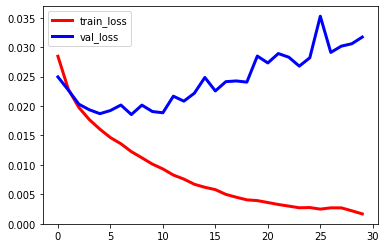

In [32]:
#plt.figure(figsize=(10, 10))
plt.plot(range(num_epoch), train_loss_list, color='red', linewidth=3.0, linestyle='-', label='train_loss')
plt.plot(range(num_epoch), val_loss_list, color='blue', linewidth=3.0, linestyle='-', label='val_loss')
plt.legend()
plt.show()

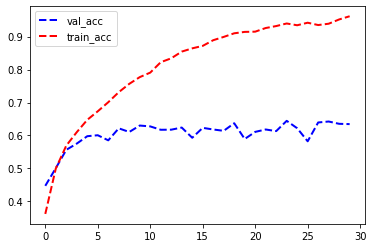

In [33]:
plt.plot(range(num_epoch), val_acc_list, color='blue', linewidth=2.0, linestyle='--', label='val_acc')
plt.plot(range(num_epoch), train_acc_list, color='red', linewidth=2.0, linestyle='--', label='train_acc')
plt.legend()
plt.show()

得到好的参数后，我们使用training set和validation set共同训练（数据量增加，模型效果一般有提升）

In [19]:
train_val_x = np.concatenate((train_files, val_files), axis=0)
train_val_y = np.concatenate((train_transform, test_transform), axis=0)
train_val_set = ImgDataset(train_val_x, train_val_y, train_transform)
train_val_loader = DataLoader(train_val_set, batch_size=batch_size, shuffle=True)

In [22]:
model_best = StudentNet(base=16).cuda()
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(model_best.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 30

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0


    model.train() # 确保 model 是在 train model (开启 Dropout 等...)
    for image, label in tqdm(train_loader):
        optimizer.zero_grad() # 用 optimizer 将 model 参数的 gradient 置零
        
        image = image.to(device)  # 如果有GPU则在GPU上运行
        label = label.to(device)
        
        train_pred = model(image) # 利用 model 得到预测的概率分布 这边实际上就是去呼叫 model 的 forward 函数
        batch_loss = loss(train_pred, label) # 计算 loss （注意 prediction 跟 label 必须同时在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個参数的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新参数值
        
        train_acc += torch.sum(torch.argmax(train_pred, dim=1) == label).item()
        train_loss += batch_loss.item()
    
    model.eval()
    with torch.no_grad():
        for image, label in tqdm(val_loader):
            image = image.to(device)
            label = label.to(device)
            
            val_pred = model(image)
            batch_loss = loss(val_pred, label)



        #將結果 print 出來
    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' % \
      (epoch + 1, num_epoch, time.time()-epoch_start_time, \
      train_acc/train_val_set.__len__(), train_loss/train_val_set.__len__()))

100%|██████████| 54/54 [00:06<00:00,  8.26it/s]


[001/030] 20.99 sec(s) Train Acc: 0.719841 Loss: 0.000972


100%|██████████| 54/54 [00:06<00:00,  8.35it/s]


[002/030] 20.58 sec(s) Train Acc: 0.717133 Loss: 0.001125


100%|██████████| 54/54 [00:06<00:00,  8.63it/s]


[003/030] 20.27 sec(s) Train Acc: 0.718111 Loss: 0.001065


100%|██████████| 54/54 [00:06<00:00,  8.67it/s]


[004/030] 20.87 sec(s) Train Acc: 0.718111 Loss: 0.001118


100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


[005/030] 20.46 sec(s) Train Acc: 0.715704 Loss: 0.001207


100%|██████████| 54/54 [00:06<00:00,  8.48it/s]


[006/030] 20.61 sec(s) Train Acc: 0.716005 Loss: 0.001134


100%|██████████| 54/54 [00:06<00:00,  8.30it/s]


[007/030] 20.56 sec(s) Train Acc: 0.719690 Loss: 0.001148


100%|██████████| 54/54 [00:06<00:00,  8.72it/s]


[008/030] 20.27 sec(s) Train Acc: 0.715328 Loss: 0.001146


100%|██████████| 54/54 [00:06<00:00,  8.72it/s]


[009/030] 20.40 sec(s) Train Acc: 0.716456 Loss: 0.001142


100%|██████████| 54/54 [00:06<00:00,  8.33it/s]


[010/030] 20.44 sec(s) Train Acc: 0.714801 Loss: 0.001239


100%|██████████| 54/54 [00:06<00:00,  8.55it/s]


[011/030] 20.87 sec(s) Train Acc: 0.716907 Loss: 0.001150


100%|██████████| 54/54 [00:06<00:00,  8.69it/s]


[012/030] 20.06 sec(s) Train Acc: 0.717735 Loss: 0.001177


100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


[013/030] 20.37 sec(s) Train Acc: 0.714952 Loss: 0.001191


100%|██████████| 54/54 [00:06<00:00,  8.65it/s]


[014/030] 20.24 sec(s) Train Acc: 0.716682 Loss: 0.001115


100%|██████████| 54/54 [00:06<00:00,  8.82it/s]


[015/030] 20.36 sec(s) Train Acc: 0.717359 Loss: 0.001094


100%|██████████| 54/54 [00:06<00:00,  8.19it/s]


[016/030] 20.42 sec(s) Train Acc: 0.717885 Loss: 0.001108


100%|██████████| 54/54 [00:06<00:00,  8.80it/s]


[017/030] 19.98 sec(s) Train Acc: 0.717058 Loss: 0.001191


100%|██████████| 54/54 [00:06<00:00,  8.64it/s]


[018/030] 20.61 sec(s) Train Acc: 0.717960 Loss: 0.001097


100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


[019/030] 20.42 sec(s) Train Acc: 0.716606 Loss: 0.001197


100%|██████████| 54/54 [00:06<00:00,  8.55it/s]


[020/030] 20.26 sec(s) Train Acc: 0.717659 Loss: 0.001131


100%|██████████| 54/54 [00:06<00:00,  8.28it/s]


[021/030] 20.49 sec(s) Train Acc: 0.718712 Loss: 0.001100


100%|██████████| 54/54 [00:06<00:00,  8.41it/s]


[022/030] 20.17 sec(s) Train Acc: 0.718788 Loss: 0.001055


100%|██████████| 54/54 [00:06<00:00,  8.41it/s]


[023/030] 20.88 sec(s) Train Acc: 0.715554 Loss: 0.001180


100%|██████████| 54/54 [00:06<00:00,  8.29it/s]


[024/030] 20.77 sec(s) Train Acc: 0.719690 Loss: 0.001119


100%|██████████| 54/54 [00:06<00:00,  8.32it/s]


[025/030] 22.10 sec(s) Train Acc: 0.717659 Loss: 0.001140


100%|██████████| 54/54 [00:06<00:00,  8.70it/s]


[026/030] 20.66 sec(s) Train Acc: 0.718487 Loss: 0.001083


100%|██████████| 54/54 [00:06<00:00,  8.45it/s]


[027/030] 20.18 sec(s) Train Acc: 0.715403 Loss: 0.001190


100%|██████████| 54/54 [00:06<00:00,  8.24it/s]


[028/030] 21.10 sec(s) Train Acc: 0.717058 Loss: 0.001051


100%|██████████| 54/54 [00:06<00:00,  8.67it/s]


[029/030] 20.83 sec(s) Train Acc: 0.715102 Loss: 0.001133


100%|██████████| 54/54 [00:06<00:00,  8.68it/s]

[030/030] 20.35 sec(s) Train Acc: 0.716230 Loss: 0.001155


原始CNN model

In [13]:
class Classifier_a(nn.Module):
    def __init__(self):
        super(Classifier_a, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 224, 224]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 112, 112]

            nn.Conv2d(64, 256, 3, 1, 1), # [256, 112, 112]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 56, 56]

            nn.AdaptiveAvgPool2d((6, 6)),
        )
        self.fc = nn.Sequential(
            nn.Linear(256*6*6, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

print("Total number of param in model is ", sum(x.numel() for x in Classifier_a().parameters()))

Total number of param in model is  251531


In [15]:
model_a =Classifier_a()
summary(model_a, (3, 512, 512), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
         MaxPool2d-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 256, 256, 256]         147,712
       BatchNorm2d-6        [-1, 256, 256, 256]             512
              ReLU-7        [-1, 256, 256, 256]               0
         MaxPool2d-8        [-1, 256, 128, 128]               0
 AdaptiveAvgPool2d-9            [-1, 256, 6, 6]               0
           Linear-10                   [-1, 11]         101,387
Total params: 251,531
Trainable params: 251,531
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.00
Forward/backward pass size (MB): 832.07
Params size (MB): 0.96
Estimated

In [16]:
model_a=model_a.to(device)
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(model_a.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 30
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model_a.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        train_pred = model_a(data[0].to(device)) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        batch_loss = loss(train_pred, data[1].to(device)) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
    
    model_a.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model_a(data[0].to(device))
            batch_loss = loss(val_pred, data[1].to(device))

            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()

        #將結果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))
        train_acc_list.append(train_acc/train_set.__len__())
        train_loss_list.append(train_loss/train_set.__len__())
        val_acc_list.append(val_acc/val_set.__len__())
        val_loss_list.append(val_loss/val_set.__len__())

[001/030] 38.80 sec(s) Train Acc: 0.293635 Loss: 0.034054 | Val Acc: 0.346064 loss: 0.030617
[002/030] 38.69 sec(s) Train Acc: 0.389722 Loss: 0.028131 | Val Acc: 0.397668 loss: 0.029314
[003/030] 38.77 sec(s) Train Acc: 0.426819 Loss: 0.026144 | Val Acc: 0.430612 loss: 0.026582
[004/030] 38.57 sec(s) Train Acc: 0.461281 Loss: 0.024652 | Val Acc: 0.420991 loss: 0.027831
[005/030] 38.74 sec(s) Train Acc: 0.487533 Loss: 0.023356 | Val Acc: 0.492420 loss: 0.023971
[006/030] 38.63 sec(s) Train Acc: 0.506892 Loss: 0.022515 | Val Acc: 0.487172 loss: 0.024347
[007/030] 38.69 sec(s) Train Acc: 0.525542 Loss: 0.021429 | Val Acc: 0.493586 loss: 0.024376
[008/030] 38.74 sec(s) Train Acc: 0.548449 Loss: 0.020639 | Val Acc: 0.501749 loss: 0.022675
[009/030] 38.84 sec(s) Train Acc: 0.553618 Loss: 0.019993 | Val Acc: 0.501458 loss: 0.022910
[010/030] 38.69 sec(s) Train Acc: 0.560511 Loss: 0.019981 | Val Acc: 0.520408 loss: 0.022585
[011/030] 38.70 sec(s) Train Acc: 0.575309 Loss: 0.019347 | Val Acc: 0

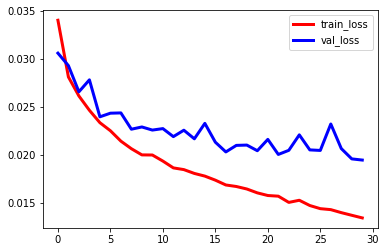

In [17]:
#plt.figure(figsize=(10, 10))
plt.plot(range(num_epoch), train_loss_list, color='red', linewidth=3.0, linestyle='-', label='train_loss')
plt.plot(range(num_epoch), val_loss_list, color='blue', linewidth=3.0, linestyle='-', label='val_loss')
plt.legend()
plt.show()

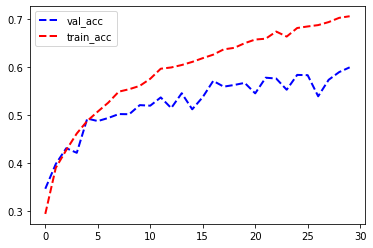

In [18]:
plt.plot(range(num_epoch), val_acc_list, color='blue', linewidth=2.0, linestyle='--', label='val_acc')
plt.plot(range(num_epoch), train_acc_list, color='red', linewidth=2.0, linestyle='--', label='train_acc')
plt.legend()
plt.show()

CNN model 的 Convolution Layer 换成总参数量接近的 Group Convolution Layer 

In [19]:
class Classifier_c(nn.Module):
    def __init__(self):
        super(Classifier_c, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 224, 224]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 112, 112]

            nn.Conv2d(64, 128, 3, 1, 1, groups = 32), # [128, 112, 112]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 56, 56]

            nn.Conv2d(128, 256, 3, 1, 1, groups = 64), # [256, 56, 56]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 28, 28]

            nn.Conv2d(256, 512, 3, 1, 1, groups = 128), # [512, 28, 28]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 14, 14]

            nn.AdaptiveAvgPool2d((3, 3)),
        )
        self.fc = nn.Sequential(
            nn.Linear(512*3*3, 48),
            nn.ReLU(),
            nn.Linear(48, 11),
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

print("Total number of param in model is ", sum(x.numel() for x in Classifier_c().parameters()))

Total number of param in model is  242507


In [20]:
model_c =Classifier_c()
summary(model_c, (3, 512, 512), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
         MaxPool2d-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 256, 256]           2,432
       BatchNorm2d-6        [-1, 128, 256, 256]             256
              ReLU-7        [-1, 128, 256, 256]               0
         MaxPool2d-8        [-1, 128, 128, 128]               0
            Conv2d-9        [-1, 256, 128, 128]           4,864
      BatchNorm2d-10        [-1, 256, 128, 128]             512
             ReLU-11        [-1, 256, 128, 128]               0
        MaxPool2d-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 512, 64, 64]           9,728
      BatchNorm2d-14          [-1, 512,

In [21]:
model_c=model_c.to(device)
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(model_c.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 30
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model_c.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        train_pred = model_c(data[0].to(device)) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        batch_loss = loss(train_pred, data[1].to(device)) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
    
    model_c.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model_c(data[0].to(device))
            batch_loss = loss(val_pred, data[1].to(device))

            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()

        #將結果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))
        train_acc_list.append(train_acc/train_set.__len__())
        train_loss_list.append(train_loss/train_set.__len__())
        val_acc_list.append(val_acc/val_set.__len__())
        val_loss_list.append(val_loss/val_set.__len__())

[001/030] 122.68 sec(s) Train Acc: 0.336712 Loss: 0.030302 | Val Acc: 0.407580 loss: 0.026646
[002/030] 122.71 sec(s) Train Acc: 0.456923 Loss: 0.024544 | Val Acc: 0.488630 loss: 0.023471
[003/030] 122.60 sec(s) Train Acc: 0.521691 Loss: 0.021817 | Val Acc: 0.486297 loss: 0.022309
[004/030] 122.61 sec(s) Train Acc: 0.557977 Loss: 0.020133 | Val Acc: 0.545773 loss: 0.020939
[005/030] 122.75 sec(s) Train Acc: 0.589601 Loss: 0.018856 | Val Acc: 0.584548 loss: 0.019340
[006/030] 122.74 sec(s) Train Acc: 0.604906 Loss: 0.018012 | Val Acc: 0.599125 loss: 0.018715
[007/030] 122.81 sec(s) Train Acc: 0.622137 Loss: 0.017227 | Val Acc: 0.598834 loss: 0.018499
[008/030] 123.17 sec(s) Train Acc: 0.623860 Loss: 0.017084 | Val Acc: 0.606997 loss: 0.018378
[009/030] 122.53 sec(s) Train Acc: 0.649605 Loss: 0.015985 | Val Acc: 0.612828 loss: 0.017654
[010/030] 122.50 sec(s) Train Acc: 0.657815 Loss: 0.015723 | Val Acc: 0.601749 loss: 0.018039
[011/030] 122.64 sec(s) Train Acc: 0.669065 Loss: 0.015055 |

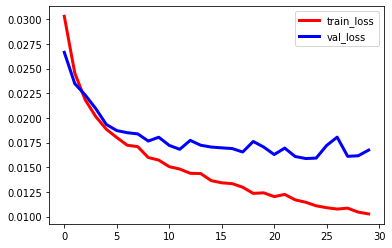

In [22]:
#plt.figure(figsize=(10, 10))
plt.plot(range(num_epoch), train_loss_list, color='red', linewidth=3.0, linestyle='-', label='train_loss')
plt.plot(range(num_epoch), val_loss_list, color='blue', linewidth=3.0, linestyle='-', label='val_loss')
plt.legend()
plt.show()

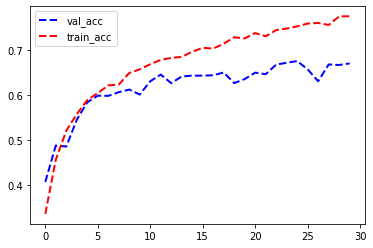

In [23]:
plt.plot(range(num_epoch), val_acc_list, color='blue', linewidth=2.0, linestyle='--', label='val_acc')
plt.plot(range(num_epoch), train_acc_list, color='red', linewidth=2.0, linestyle='--', label='train_acc')
plt.legend()
plt.show()

# 课程设计 - Network Compression_2 (Knowledge Distillation)

In [ ]:
# 更新库
! python -m pip install --upgrade pip
! pip install -U albumentations
! pip install timm
! pip install torchsummary
!pip install matplotlib

In [ ]:
import moxing as mox 
# 需修改为自己的OBS目录
mox.file.copy('obs://tong-network/food-11.zip', '/home/ma-user/work/food-11.zip') # 复制数据到当前路径

In [ ]:
# 解压
!unzip food-11.zip

In [ ]:
import torch
import os
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

In [ ]:
class StudentNet(nn.Module):

    def __init__(self, base=16, width_mult=1):
        super(StudentNet, self).__init__()
        multiplier = [1, 2, 4, 8, 16, 16, 18, 18]
        bandwidth = [ base * m for m in multiplier]
        for i in range(3, 7):
            bandwidth[i] = int(bandwidth[i] * width_mult)
        self.cnn = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(3, bandwidth[0], 3, 1, 1), 
                nn.BatchNorm2d(bandwidth[0]),
                nn.Hardswish(),
                nn.MaxPool2d(2, 2, 0),
            ),
            nn.Sequential(
                nn.Conv2d(bandwidth[0], bandwidth[0], 3, 1, 1, groups=bandwidth[0]),
                nn.BatchNorm2d(bandwidth[0]),
                nn.Hardswish(),
                nn.Conv2d(bandwidth[0], bandwidth[1], 1),
                nn.MaxPool2d(2, 2, 0),
            ),

            nn.Sequential(
                nn.Conv2d(bandwidth[1], bandwidth[1], 3, 1, 1, groups=bandwidth[1]),
                nn.BatchNorm2d(bandwidth[1]),
                nn.Hardswish(),
                nn.Conv2d(bandwidth[1], bandwidth[2], 1),
                nn.MaxPool2d(2, 2, 0),
            ),

            nn.Sequential(
                nn.Conv2d(bandwidth[2], bandwidth[2], 3, 1, 1, groups=bandwidth[2]),
                nn.BatchNorm2d(bandwidth[2]),
                nn.Hardswish(),
                nn.Conv2d(bandwidth[2], bandwidth[3], 1),
                nn.MaxPool2d(2, 2, 0),
            ),
            nn.Sequential(
                nn.Conv2d(bandwidth[3], bandwidth[3], 3, 1, 1, groups=bandwidth[3]),
                nn.BatchNorm2d(bandwidth[3]),
                nn.Hardswish(),
                nn.Conv2d(bandwidth[3], bandwidth[4], 1),
            ),

            nn.Sequential(
                nn.Conv2d(bandwidth[4], bandwidth[4], 3, 1, 1, groups=bandwidth[4]),
                nn.BatchNorm2d(bandwidth[4]),
                nn.Hardswish(),
                nn.Conv2d(bandwidth[4], bandwidth[5], 1),
            ),

            nn.Sequential(
                nn.Conv2d(bandwidth[5], bandwidth[5], 3, 1, 1, groups=bandwidth[5]),
                nn.BatchNorm2d(bandwidth[5]),
                nn.Hardswish(),
                nn.Conv2d(bandwidth[5], bandwidth[6], 1),
            ),

            nn.Sequential(
                nn.Conv2d(bandwidth[6], bandwidth[6], 3, 1, 1, groups=bandwidth[6]),
                nn.BatchNorm2d(bandwidth[6]),
                nn.Hardswish(),
                nn.Conv2d(bandwidth[6], bandwidth[7], 1),
            ),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Sequential(
            nn.Linear(bandwidth[7], 11),
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)


In [ ]:
from torchsummary import summary

student_net = StudentNet()
summary(student_net, (3, 512, 512), device="cpu")

In [ ]:
def loss_fn_kd(outputs, labels, teacher_outputs, T=20, alpha=0.5):
    # 一般的Cross Entropy
    hard_loss = F.cross_entropy(outputs, labels) * (1. - alpha)
    # 讓logits的log_softmax對目標機率(teacher的logits/T後softmax)做KL Divergence。
    soft_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T)
    return hard_loss + soft_loss

In [ ]:
import re
import torch
from glob import glob
from PIL import Image
import torchvision.transforms as transforms

class MyDataset(torch.utils.data.Dataset):

    def __init__(self, folderName, transform=None):
        self.transform = transform
        self.data = []
        self.label = []

        for img_path in sorted(glob(folderName + '/*.jpg')):
            try:
                # Get classIdx by parsing image path
                class_idx = int(re.findall(re.compile(r'\d+'), img_path)[1])
            except:
                # if inference mode (there's no answer), class_idx default 0
                class_idx = 0

            image = Image.open(img_path)
            # Get File Descriptor
            image_fp = image.fp
            image.load()
            # Close File Descriptor (or it'll reach OPEN_MAX)
            image_fp.close()

            self.data.append(image)
            self.label.append(class_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.label[idx]


trainTransform = transforms.Compose([
    transforms.RandomCrop(256, pad_if_needed=True, padding_mode='symmetric'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])
testTransform = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.ToTensor(),
])

def get_dataloader(mode='training', batch_size=32):

    assert mode in ['training', 'testing', 'validation']

    dataset = MyDataset(
        f'./food-11/{mode}',
        transform=trainTransform if mode == 'training' else testTransform)

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=(mode == 'training'))

    return dataloader
def val_dataloader( batch_size=32):
    dataset = MyDataset(f'./food-11/validation',transform= trainTransform)
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
    return dataloader


In [ ]:
# get dataloader
train_dataloader = get_dataloader('training', batch_size=32)
valid_dataloader = get_dataloader('validation', batch_size=32)
valtrain_dataloader = val_dataloader( batch_size=32)

In [ ]:
teacher_net = models.resnet18(pretrained=False, num_classes=11).cuda()
student_net = StudentNet(base=16).cuda()

# 载入老师模型
teacher_net.load_state_dict(torch.load(f'./teacher_resnet18.bin'))
optimizer = optim.AdamW(student_net.parameters(), lr=1e-3)

In [ ]:
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
def run_epoch(dataloader, update=True, alpha=0.5):
    total_num, total_hit, total_loss = 0, 0, 0
    for now_step, batch_data in enumerate(dataloader):
        # 清空 optimizer
        optimizer.zero_grad()
        # 處理 input
        inputs, hard_labels = batch_data
        inputs = inputs.cuda()
        hard_labels = torch.LongTensor(hard_labels).cuda()
        # 因為Teacher沒有要backprop，所以我們使用torch.no_grad
        # 告訴torch不要暫存中間值(去做backprop)以浪費記憶體空間。
        with torch.no_grad():
            soft_labels = teacher_net(inputs)

        if update:
            logits = student_net(inputs)
            # 使用我們之前所寫的融合soft label&hard label的loss。
            # T=20是原始論文的參數設定。
            loss = loss_fn_kd(logits, hard_labels, soft_labels, 20, alpha)
            loss.backward()
            optimizer.step()    
        else:
            # 只是算validation acc的話，就開no_grad節省空間。
            with torch.no_grad():
                logits = student_net(inputs)
                loss = loss_fn_kd(logits, hard_labels, soft_labels, 20, alpha)
            
        total_hit += torch.sum(torch.argmax(logits, dim=1) == hard_labels).item()
        total_num += len(inputs)

        total_loss += loss.item() * len(inputs)
    return total_loss / total_num, total_hit / total_num


# TeacherNet永遠都是Eval mode.
teacher_net.eval()
now_best_acc = 0
for epoch in range(30):  # 200
    student_net.train()
    train_loss, train_acc = run_epoch(train_dataloader, update=True)
    student_net.eval()
    valid_loss, valid_acc = run_epoch(valid_dataloader, update=False)

    # 存下最好的model。
    if valid_acc > now_best_acc:
        now_best_acc = valid_acc
        torch.save(student_net.state_dict(), 'student_model.bin')  
    print('epoch {:>3d}: train loss: {:6.4f}, acc {:6.4f} valid loss: {:6.4f}, acc {:6.4f}'.format(
    epoch, train_loss, train_acc, valid_loss, valid_acc))
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(valid_acc)
    val_loss_list.append(valid_loss)


In [ ]:
plt.plot(range(30), train_loss_list, color='red', linewidth=3.0, linestyle='-', label='train_loss')
plt.plot(range(30), val_loss_list, color='blue', linewidth=3.0, linestyle='-', label='val_loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(range(30), val_acc_list, color='blue', linewidth=2.0, linestyle='--', label='val_acc')
plt.plot(range(30), train_acc_list, color='red', linewidth=2.0, linestyle='--', label='train_acc')
plt.legend()
plt.show()

Final model

In [ ]:
student_net = StudentNet(base=16).cuda()
optimizer = optim.Adam(student_net.parameters(), lr=1e-3)

In [ ]:
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
def run_epoch(dataloader, update=True, alpha=0.5):
    total_num, total_hit, total_loss = 0, 0, 0
    for now_step, batch_data in enumerate(dataloader):
        # 清空 optimizer
        optimizer.zero_grad()
        # 處理 input
        inputs, hard_labels = batch_data
        inputs = inputs.cuda()
        hard_labels = torch.LongTensor(hard_labels).cuda()
        # 因為Teacher沒有要backprop，所以我們使用torch.no_grad
        # 告訴torch不要暫存中間值(去做backprop)以浪費記憶體空間。
        with torch.no_grad():
            soft_labels = teacher_net(inputs)

        if update:
            logits = student_net(inputs)
            # 使用我們之前所寫的融合soft label&hard label的loss。
            # T=20是原始論文的參數設定。
            loss = loss_fn_kd(logits, hard_labels, soft_labels, 20, alpha)
            loss.backward()
            optimizer.step()    
        else:
            # 只是算validation acc的話，就開no_grad節省空間。
            with torch.no_grad():
                logits = student_net(inputs)
                loss = loss_fn_kd(logits, hard_labels, soft_labels, 20, alpha)
            
        total_hit += torch.sum(torch.argmax(logits, dim=1) == hard_labels).item()
        total_num += len(inputs)

        total_loss += loss.item() * len(inputs)
    return total_loss / total_num, total_hit / total_num


# TeacherNet永遠都是Eval mode.
teacher_net.eval()
now_best_acc = 0
for epoch in range(30):  # 200
    student_net.train()
    train_loss, train_acc = run_epoch(train_dataloader, update=True)
    valid_loss, valid_acc = run_epoch(valtrain_dataloader, update=True)

    print('epoch {:>3d}: train loss: {:6.4f}, acc {:6.4f} valid loss: {:6.4f}, acc {:6.4f}'.format(
    epoch, train_loss, train_acc, valid_loss, valid_acc))
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(valid_acc)
    val_loss_list.append(valid_loss)
torch.save(student_net.state_dict(), 'student_model.bin')  

In [ ]:
model = StudentNet(base=16)
model.load_state_dict(torch.load('student_model.bin'))
model.eval()
input_tensor = torch.rand(1,3,224,224)
script_model = torch.jit.trace(model,input_tensor)
script_model.save("model.pt")

In [ ]:
# 把模型保存至obs中，在home page即可下载,记得换为自己的obs路径，保存的模型在test.ipynb中使用
mox.file.copy( '/home/ma-user/work/student_model.bin','obs://test-c3a5') 